In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
regression_df = pd.read_csv("regression_df_official.csv")

In [28]:
regression_df = regression_df.drop(columns=['days_since_promo'], errors='ignore')


In [29]:
print("Data shape:", regression_df.shape)
print("Columns:", regression_df.columns.tolist())
regression_df.head()


Data shape: (1023, 55)
Columns: ['date', 'package_count', 'day_of_week', 'is_friday', 'is_holiday', 'is_after_holiday', 'is_manual_closure', 'is_closed_day', 'is_post_event_window', 'is_open_day', 'day_after_closed', 'lag1', 'lag7', 'rolling7', 'rolling14', 'rolling30', 'growth_rate', 'is_active_SG', 'is_active_CZ', 'is_active_AE', 'is_active_MY', 'is_active_CN', 'SG', 'CZ', 'AE', 'MY', 'CN', 'FR', 'NL', 'growth_SG', 'growth_CZ', 'growth_AE', 'growth_MY', 'growth_CN', 'rolling7_SG', 'rolling7_CZ', 'rolling7_AE', 'rolling7_MY', 'rolling7_CN', 'share_SG', 'share_CZ', 'share_AE', 'share_MY', 'share_CN', 'month', 'day_of_year', 'weekofyear', 'n_active_china_routes', 'dominant_country', 'china_rolling7_std', 'is_promo_day', 'total_china_rerouted', 'is_big_jump', 'is_outlier', 'is_iqr_outlier']


,date,package_count,day_of_week,is_friday,is_holiday,is_after_holiday,is_manual_closure,is_closed_day,is_post_event_window,is_open_day,...,day_of_year,weekofyear,n_active_china_routes,dominant_country,china_rolling7_std,is_promo_day,total_china_rerouted,is_big_jump,is_outlier,is_iqr_outlier
0,2022-01-03,1,0,0,0,0,0,0,0,1,...,3,1,0,SG,0.000000,0,0,0,0,0
1,2022-01-04,8,1,0,0,0,0,0,0,1,...,4,1,0,SG,0.000000,0,0,1,0,0
2,2022-01-05,186,2,0,0,0,0,0,0,1,...,5,1,0,SG,99.881597,0,173,1,0,0
3,2022-01-06,807,3,0,0,0,0,0,0,1,...,6,1,0,SG,366.846471,0,773,0,0,0
4,2022-01-08,595,5,0,0,0,0,0,0,1,...,8,1,0,SG,349.088384,0,560,0,0,0


In [30]:
# Identify object (categorical) columns (except 'date')
categorical_cols = [col for col in regression_df.columns if regression_df[col].dtype == 'O' and col != 'date']

print("Categorical columns to encode:", categorical_cols)

# One-hot encode these columns (excluding the first category to avoid collinearity)
df_encoded = pd.get_dummies(regression_df, columns=categorical_cols, drop_first=True)

print("After encoding, shape:", df_encoded.shape)
df_encoded.head()


Categorical columns to encode: ['dominant_country']
After encoding, shape: (1023, 58)


,date,package_count,day_of_week,is_friday,is_holiday,is_after_holiday,is_manual_closure,is_closed_day,is_post_event_window,is_open_day,...,china_rolling7_std,is_promo_day,total_china_rerouted,is_big_jump,is_outlier,is_iqr_outlier,dominant_country_CN,dominant_country_CZ,dominant_country_MY,dominant_country_SG
0,2022-01-03,1,0,0,0,0,0,0,0,1,...,0.000000,0,0,0,0,0,False,False,False,True
1,2022-01-04,8,1,0,0,0,0,0,0,1,...,0.000000,0,0,1,0,0,False,False,False,True
2,2022-01-05,186,2,0,0,0,0,0,0,1,...,99.881597,0,173,1,0,0,False,False,False,True
3,2022-01-06,807,3,0,0,0,0,0,0,1,...,366.846471,0,773,0,0,0,False,False,False,True
4,2022-01-08,595,5,0,0,0,0,0,0,1,...,349.088384,0,560,0,0,0,False,False,False,True


In [62]:
df = df_encoded.copy()

# === Define columns to lag ===
country_cols = ['SG', 'CZ', 'AE', 'MY', 'CN', 'FR', 'NL']
growth_cols = ['growth_SG', 'growth_CZ', 'growth_AE', 'growth_MY', 'growth_CN']
rolling_cols = ['rolling7', 'rolling14', 'rolling30',
                'rolling7_SG', 'rolling7_CZ', 'rolling7_AE', 'rolling7_MY', 'rolling7_CN']
share_cols = ['share_SG', 'share_CZ', 'share_AE', 'share_MY', 'share_CN']
other_to_shift = ['china_rolling7_std', 'total_china_rerouted', 'growth_rate']

# Add lags 2-6 for y
for l in range(2, 7):
    df[f'lag{l}'] = df['package_count'].shift(l)

# Shift all rollings, growths, shares, stds, total reroute, growth_rate, and countries (lag1 only)
for col in country_cols + growth_cols + rolling_cols + share_cols + other_to_shift:
    if col in df.columns:
        df[f'{col}_lag1'] = df[col].shift(1)

# Drop forbidden columns (do NOT drop 'date' or 'package_count' yet)
drop_cols = [
    'is_open_day', 'is_big_jump', 'is_outlier', 'is_iqr_outlier'
]
drop_cols += country_cols + growth_cols + rolling_cols + share_cols + other_to_shift

for col in drop_cols:
    if col in df.columns:
        df = df.drop(columns=col)

df = df.rename(columns={'date': 'ds', 'package_count': 'y'})
print("After shifting and dropping forbidden columns, shape:", df.shape)
df.head()


After shifting and dropping forbidden columns, shape: (1023, 59)


,ds,y,day_of_week,is_friday,is_holiday,is_after_holiday,is_manual_closure,is_closed_day,is_post_event_window,day_after_closed,...,rolling7_MY_lag1,rolling7_CN_lag1,share_SG_lag1,share_CZ_lag1,share_AE_lag1,share_MY_lag1,share_CN_lag1,china_rolling7_std_lag1,total_china_rerouted_lag1,growth_rate_lag1
0,2022-01-03,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-04,8,1,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,NaN
2,2022-01-05,186,2,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,7.00000
3,2022-01-06,807,3,0,0,0,0,0,0,0,...,0.0,0.0,0.994220,0.0,0.005780,0.000000,0.0,99.881597,173.0,22.25000
4,2022-01-08,595,5,0,0,0,0,0,0,0,...,9.0,0.0,0.952135,0.0,0.001294,0.046572,0.0,366.846471,773.0,3.33871


In [63]:
df.columns

Index(['ds', 'y', 'day_of_week', 'is_friday', 'is_holiday', 'is_after_holiday',
       'is_manual_closure', 'is_closed_day', 'is_post_event_window',
       'day_after_closed', 'lag1', 'lag7', 'is_active_SG', 'is_active_CZ',
       'is_active_AE', 'is_active_MY', 'is_active_CN', 'month', 'day_of_year',
       'weekofyear', 'n_active_china_routes', 'is_promo_day',
       'dominant_country_CN', 'dominant_country_CZ', 'dominant_country_MY',
       'dominant_country_SG', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6',
       'SG_lag1', 'CZ_lag1', 'AE_lag1', 'MY_lag1', 'CN_lag1', 'FR_lag1',
       'NL_lag1', 'growth_SG_lag1', 'growth_CZ_lag1', 'growth_AE_lag1',
       'growth_MY_lag1', 'growth_CN_lag1', 'rolling7_lag1', 'rolling14_lag1',
       'rolling30_lag1', 'rolling7_SG_lag1', 'rolling7_CZ_lag1',
       'rolling7_AE_lag1', 'rolling7_MY_lag1', 'rolling7_CN_lag1',
       'share_SG_lag1', 'share_CZ_lag1', 'share_AE_lag1', 'share_MY_lag1',
       'share_CN_lag1', 'china_rolling7_std_lag1', 'total_c

In [64]:
# Check number of missing values in each feature column
missing_counts = df.isnull().sum()

# Only show features with missing values
missing_counts = missing_counts[missing_counts > 0]
print("Features with missing values and their counts:\n", missing_counts)


Features with missing values and their counts:
 lag1                         1
lag7                         7
lag2                         2
lag3                         3
lag4                         4
lag5                         5
lag6                         6
SG_lag1                      1
CZ_lag1                      1
AE_lag1                      1
MY_lag1                      1
CN_lag1                      1
FR_lag1                      1
NL_lag1                      1
growth_SG_lag1               1
growth_CZ_lag1               1
growth_AE_lag1               1
growth_MY_lag1               1
growth_CN_lag1               1
rolling7_lag1                1
rolling14_lag1               1
rolling30_lag1               1
rolling7_SG_lag1             1
rolling7_CZ_lag1             1
rolling7_AE_lag1             1
rolling7_MY_lag1             1
rolling7_CN_lag1             1
share_SG_lag1                1
share_CZ_lag1                1
share_AE_lag1                1
share_MY_lag1         

In [32]:
# Only keep numeric columns for Prophet (ds, y, and features)
feature_cols = [col for col in df.columns if col not in ['ds', 'y']]
numeric_cols = [col for col in feature_cols if np.issubdtype(df[col].dtype, np.number)]

final_cols = ['ds', 'y'] + numeric_cols
df_prophet = df[final_cols]

# Remove rows with any NA (from shifting)
df_prophet = df_prophet.dropna().reset_index(drop=True)

print("Final Prophet DataFrame shape:", df_prophet.shape)
df_prophet.head()


Final Prophet DataFrame shape: (1016, 55)


,ds,y,day_of_week,is_friday,is_holiday,is_after_holiday,is_manual_closure,is_closed_day,is_post_event_window,day_after_closed,...,rolling7_MY_lag1,rolling7_CN_lag1,share_SG_lag1,share_CZ_lag1,share_AE_lag1,share_MY_lag1,share_CN_lag1,china_rolling7_std_lag1,total_china_rerouted_lag1,growth_rate_lag1
0,2022-01-11,97,1,0,0,0,0,0,0,0,...,20.428571,0.285714,0.001079,0.935275,0.005933,0.057713,0.000000,916.642320,1854.0,-0.124240
1,2022-01-13,2105,3,0,0,0,0,0,0,0,...,20.428571,0.428571,0.000000,0.983607,0.000000,0.000000,0.016393,907.949967,61.0,-0.951885
2,2022-01-15,6313,5,0,0,0,0,0,0,0,...,31.714286,0.428571,0.000000,0.960622,0.000972,0.038405,0.000000,932.800571,2057.0,20.701031
3,2022-01-16,613,6,0,0,0,0,0,0,0,...,42.428571,0.428571,0.982520,0.001279,0.000213,0.015988,0.000000,1541.744945,4691.0,1.999050
4,2022-01-17,964,0,0,0,0,0,0,0,0,...,50.714286,0.428571,0.171642,0.074627,0.052239,0.701493,0.000000,1626.128063,134.0,-0.902899


In [33]:
from prophet import Prophet

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
for col in numeric_cols:
    m.add_regressor(col)

model = m.fit(df_prophet)


20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing


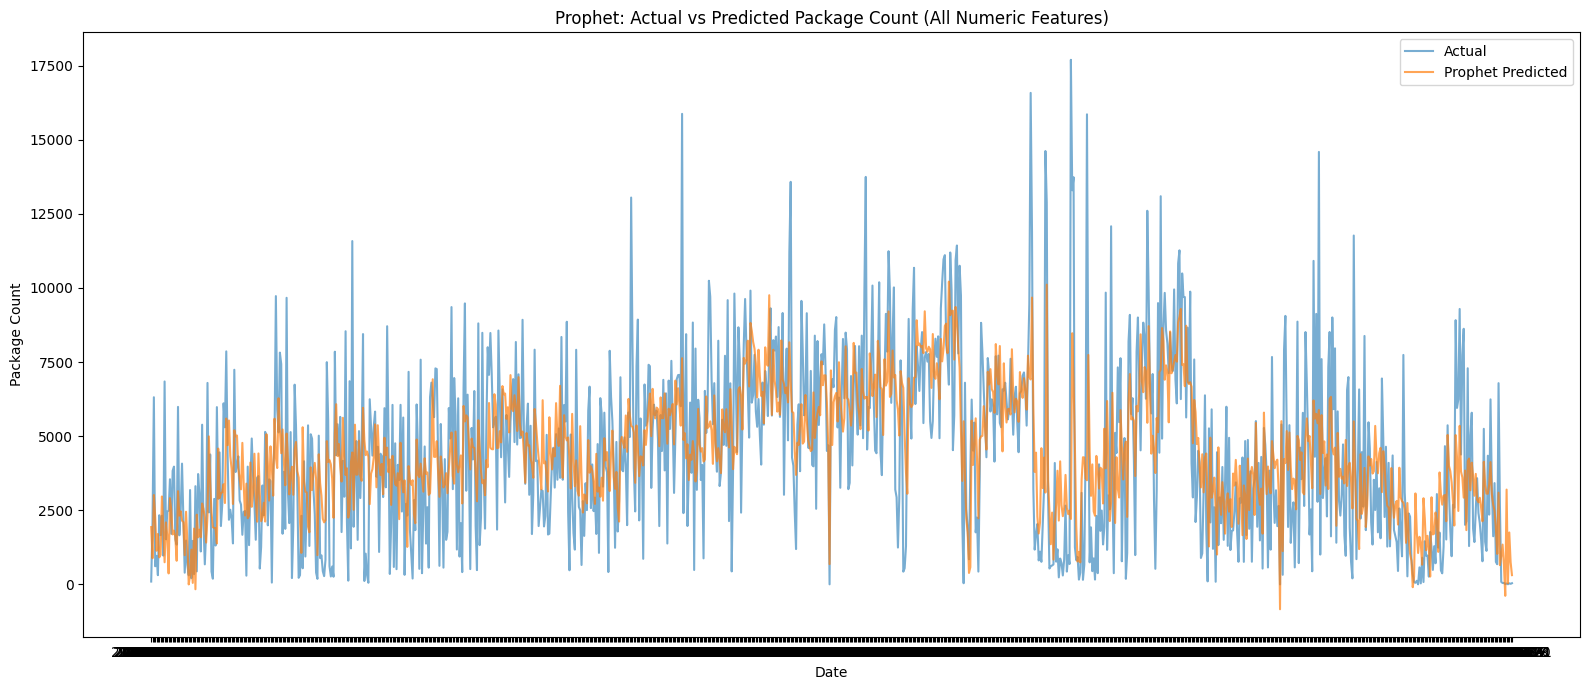

In [34]:
forecast = m.predict(df_prophet)

import matplotlib.pyplot as plt
plt.figure(figsize=(16,7))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', alpha=0.6)
plt.plot(df_prophet['ds'], forecast['yhat'], label='Prophet Predicted', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Package Count")
plt.title("Prophet: Actual vs Predicted Package Count (All Numeric Features)")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
import numpy as np

y_true = df_prophet['y'].values
y_pred = forecast['yhat'].values

# MAE
mae = np.mean(np.abs(y_true - y_pred))

# RMSE
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

# R2 (Coefficient of Determination)
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
r2 = 1 - ss_res / ss_tot

print("Prophet (manual):")
print(f"MAE: {mae:.1f}")
print(f"RMSE: {rmse:.1f}")
print(f"R²: {r2:.4f}")


Prophet (manual):
MAE: 1786.4
RMSE: 2350.5
R²: 0.3992


In [36]:
df_prophet.columns

Index(['ds', 'y', 'day_of_week', 'is_friday', 'is_holiday', 'is_after_holiday',
       'is_manual_closure', 'is_closed_day', 'is_post_event_window',
       'day_after_closed', 'lag1', 'lag7', 'is_active_SG', 'is_active_CZ',
       'is_active_AE', 'is_active_MY', 'is_active_CN', 'month', 'day_of_year',
       'weekofyear', 'n_active_china_routes', 'is_promo_day', 'lag2', 'lag3',
       'lag4', 'lag5', 'lag6', 'SG_lag1', 'CZ_lag1', 'AE_lag1', 'MY_lag1',
       'CN_lag1', 'FR_lag1', 'NL_lag1', 'growth_SG_lag1', 'growth_CZ_lag1',
       'growth_AE_lag1', 'growth_MY_lag1', 'growth_CN_lag1', 'rolling7_lag1',
       'rolling14_lag1', 'rolling30_lag1', 'rolling7_SG_lag1',
       'rolling7_CZ_lag1', 'rolling7_AE_lag1', 'rolling7_MY_lag1',
       'rolling7_CN_lag1', 'share_SG_lag1', 'share_CZ_lag1', 'share_AE_lag1',
       'share_MY_lag1', 'share_CN_lag1', 'china_rolling7_std_lag1',
       'total_china_rerouted_lag1', 'growth_rate_lag1'],
      dtype='object')

In [37]:
prophet_feats = [
    'day_of_week', 'month', 'day_of_year', 'weekofyear',
    'lag1', 'lag7', 'is_holiday', 'is_promo_day',
    'SG_lag1', 'AE_lag1', 'CZ_lag1'
]


In [38]:
from prophet import Prophet

df_prophet_small = df_prophet[['ds', 'y'] + prophet_feats].copy()

m = Prophet()
for col in prophet_feats:
    m.add_regressor(col)

model = m.fit(df_prophet_small)
forecast = m.predict(df_prophet_small)


20:37:07 - cmdstanpy - INFO - Chain [1] start processing
20:37:07 - cmdstanpy - INFO - Chain [1] done processing


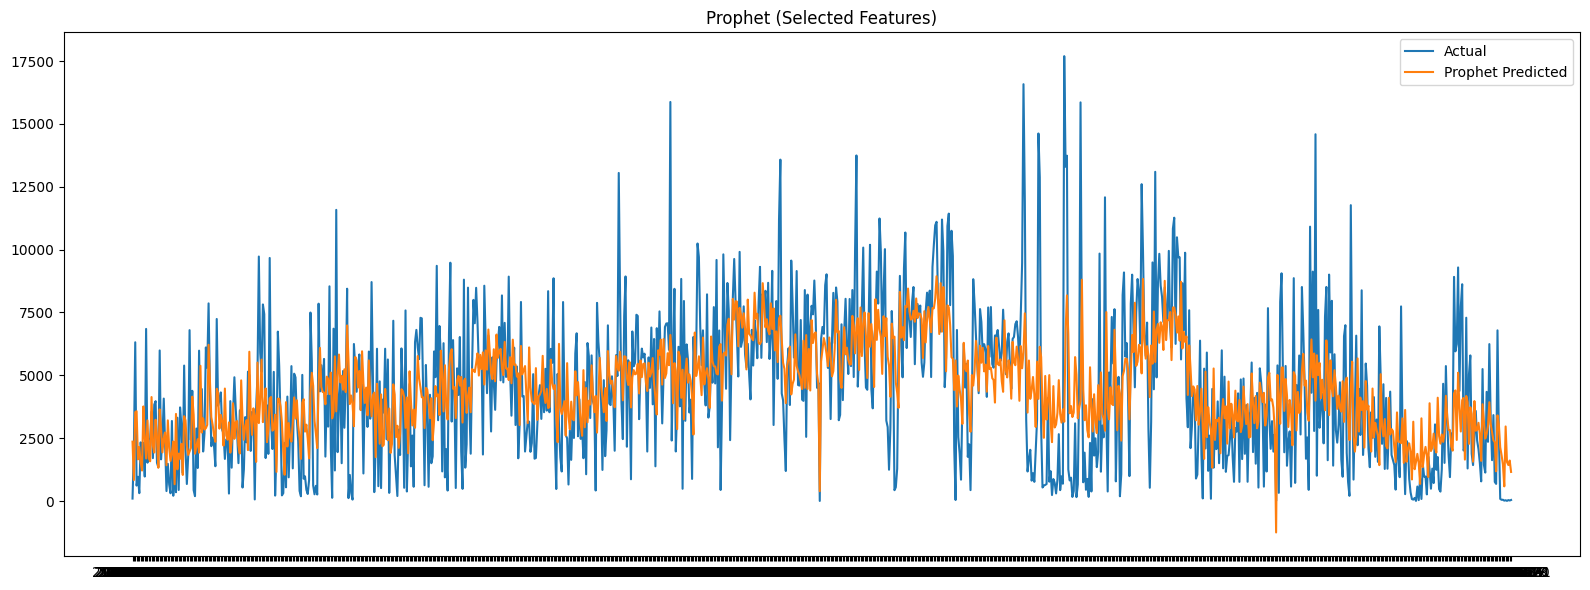

MAE: 1920.0
RMSE: 2500.6
R²: 0.3201


In [39]:
import matplotlib.pyplot as plt
actual = df_prophet_small['y'].values
pred = forecast['yhat'].values

plt.figure(figsize=(16,6))
plt.plot(df_prophet_small['ds'], actual, label='Actual')
plt.plot(df_prophet_small['ds'], pred, label='Prophet Predicted')
plt.legend()
plt.title('Prophet (Selected Features)')
plt.tight_layout()
plt.show()

# Metrics
import numpy as np
mae = np.mean(np.abs(actual - pred))
rmse = np.sqrt(np.mean((actual - pred)**2))
ss_tot = np.sum((actual - np.mean(actual))**2)
ss_res = np.sum((actual - pred)**2)
r2 = 1 - ss_res / ss_tot

print(f"MAE: {mae:.1f}")
print(f"RMSE: {rmse:.1f}")
print(f"R²: {r2:.4f}")


In [40]:
combinations = [
    # 1. Basic time features
    ['day_of_week', 'month', 'day_of_year', 'weekofyear'],
    # 2. + Lags
    ['day_of_week', 'month', 'lag1'],
    ['day_of_week', 'month', 'lag1', 'lag7'],
    # 3. + Holidays/Promo
    ['day_of_week', 'is_holiday', 'is_promo_day'],
    ['day_of_week', 'lag1', 'lag7', 'is_holiday', 'is_promo_day'],
    # 4. + All available lags
    ['day_of_week', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6'],
    # 5. + Countries lag1
    ['day_of_week', 'lag1', 'SG_lag1', 'AE_lag1'],
    ['day_of_week', 'lag1', 'SG_lag1', 'AE_lag1', 'CZ_lag1'],
    # 6. + Growths (only lags)
    ['day_of_week', 'lag1', 'growth_SG_lag1', 'growth_AE_lag1'],
    ['day_of_week', 'lag1', 'growth_SG_lag1', 'growth_AE_lag1', 'growth_CN_lag1'],
    # 7. + Rolling
    ['day_of_week', 'lag1', 'rolling7_lag1', 'rolling14_lag1'],
    # 8. + More countries/flags
    ['day_of_week', 'lag1', 'SG_lag1', 'CZ_lag1', 'MY_lag1', 'is_promo_day'],
    # 9. + All countries lag1 + promo/holiday
    ['day_of_week', 'lag1', 'SG_lag1', 'CZ_lag1', 'AE_lag1', 'MY_lag1', 'CN_lag1', 'is_promo_day', 'is_holiday'],
    # 10. + All time signals, all lags
    ['day_of_week', 'month', 'lag1', 'lag7', 'is_holiday', 'is_promo_day'],
    # 11. + day_of_year, month, lag1, rolling7
    ['day_of_year', 'month', 'lag1', 'rolling7_lag1'],
    # 12. + rolling7 and growth rate lag1
    ['day_of_week', 'lag1', 'rolling7_lag1', 'growth_rate_lag1'],
    # 13. + country shares (lag1)
    ['day_of_week', 'lag1', 'share_SG_lag1', 'share_AE_lag1', 'share_CN_lag1'],
    # 14. + promo/holiday and all lags
    ['day_of_week', 'month', 'is_holiday', 'is_promo_day', 'lag1', 'lag2', 'lag7'],
    # 15. + rolling7, country lags, promo
    ['day_of_week', 'lag1', 'rolling7_lag1', 'SG_lag1', 'is_promo_day'],
    # 16. + all main countries, all rolling7, main flags
    ['day_of_week', 'lag1', 'SG_lag1', 'AE_lag1', 'CZ_lag1', 'rolling7_lag1', 'is_promo_day'],
    # 17. + everything except rolling/shares/growths
    ['day_of_week', 'month', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'SG_lag1', 'AE_lag1', 'CZ_lag1', 'MY_lag1', 'CN_lag1', 'is_promo_day', 'is_holiday'],
    # 18. All time, lag1, all rolling, promo/holiday
    ['day_of_week', 'month', 'day_of_year', 'weekofyear', 'lag1', 'rolling7_lag1', 'rolling14_lag1', 'rolling30_lag1', 'is_holiday', 'is_promo_day'],
    # 19. Only lags and country lags
    ['lag1', 'lag2', 'lag3', 'SG_lag1', 'AE_lag1', 'CZ_lag1'],
    # 20. Only rolling and lags
    ['lag1', 'lag7', 'rolling7_lag1', 'rolling14_lag1'],
]


In [41]:
from prophet import Prophet
import numpy as np

results = []
for i, feat_set in enumerate(combinations):
    print(f"Trying combo {i+1}: {feat_set}")
    df_test = df_prophet[['ds', 'y'] + feat_set].copy()
    # Prophet can't take NaNs
    df_test = df_test.dropna()
    m = Prophet()
    for col in feat_set:
        m.add_regressor(col)
    model = m.fit(df_test)
    forecast = m.predict(df_test)
    actual = df_test['y'].values
    pred = forecast['yhat'].values

    mae = np.mean(np.abs(actual - pred))
    rmse = np.sqrt(np.mean((actual - pred)**2))
    ss_tot = np.sum((actual - np.mean(actual))**2)
    ss_res = np.sum((actual - pred)**2)
    r2 = 1 - ss_res / ss_tot
    print(f"Combo {i+1} - MAE: {mae:.1f} | RMSE: {rmse:.1f} | R²: {r2:.4f}\n")
    results.append({
        'combo': i+1,
        'features': feat_set,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    })

# Find best combo
results_sorted = sorted(results, key=lambda d: d['mae'])
print("==== Best Results by MAE ====")
for r in results_sorted[:5]:
    print(f"Combo {r['combo']}: MAE={r['mae']:.1f}, RMSE={r['rmse']:.1f}, R²={r['r2']:.4f}, Features={r['features']}")


20:39:43 - cmdstanpy - INFO - Chain [1] start processing


Trying combo 1: ['day_of_week', 'month', 'day_of_year', 'weekofyear']


20:39:43 - cmdstanpy - INFO - Chain [1] done processing
20:39:44 - cmdstanpy - INFO - Chain [1] start processing


Combo 1 - MAE: 1992.9 | RMSE: 2587.8 | R²: 0.2718

Trying combo 2: ['day_of_week', 'month', 'lag1']


20:39:44 - cmdstanpy - INFO - Chain [1] done processing
20:39:44 - cmdstanpy - INFO - Chain [1] start processing


Combo 2 - MAE: 1946.8 | RMSE: 2517.2 | R²: 0.3110

Trying combo 3: ['day_of_week', 'month', 'lag1', 'lag7']


20:39:44 - cmdstanpy - INFO - Chain [1] done processing
20:39:44 - cmdstanpy - INFO - Chain [1] start processing
20:39:44 - cmdstanpy - INFO - Chain [1] done processing


Combo 3 - MAE: 1941.6 | RMSE: 2515.4 | R²: 0.3119

Trying combo 4: ['day_of_week', 'is_holiday', 'is_promo_day']


20:39:45 - cmdstanpy - INFO - Chain [1] start processing


Combo 4 - MAE: 1993.6 | RMSE: 2588.8 | R²: 0.2712

Trying combo 5: ['day_of_week', 'lag1', 'lag7', 'is_holiday', 'is_promo_day']


20:39:45 - cmdstanpy - INFO - Chain [1] done processing
20:39:45 - cmdstanpy - INFO - Chain [1] start processing


Combo 5 - MAE: 1941.4 | RMSE: 2514.9 | R²: 0.3123

Trying combo 6: ['day_of_week', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6']


20:39:45 - cmdstanpy - INFO - Chain [1] done processing
20:39:46 - cmdstanpy - INFO - Chain [1] start processing


Combo 6 - MAE: 1915.1 | RMSE: 2503.8 | R²: 0.3183

Trying combo 7: ['day_of_week', 'lag1', 'SG_lag1', 'AE_lag1']


20:39:46 - cmdstanpy - INFO - Chain [1] done processing
20:39:46 - cmdstanpy - INFO - Chain [1] start processing


Combo 7 - MAE: 1926.0 | RMSE: 2503.4 | R²: 0.3185

Trying combo 8: ['day_of_week', 'lag1', 'SG_lag1', 'AE_lag1', 'CZ_lag1']


20:39:46 - cmdstanpy - INFO - Chain [1] done processing
20:39:46 - cmdstanpy - INFO - Chain [1] start processing


Combo 8 - MAE: 1923.9 | RMSE: 2501.9 | R²: 0.3194

Trying combo 9: ['day_of_week', 'lag1', 'growth_SG_lag1', 'growth_AE_lag1']


20:39:46 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing


Combo 9 - MAE: 1946.8 | RMSE: 2516.4 | R²: 0.3114

Trying combo 10: ['day_of_week', 'lag1', 'growth_SG_lag1', 'growth_AE_lag1', 'growth_CN_lag1']


20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing


Combo 10 - MAE: 1939.6 | RMSE: 2510.6 | R²: 0.3146

Trying combo 11: ['day_of_week', 'lag1', 'rolling7_lag1', 'rolling14_lag1']


20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing


Combo 11 - MAE: 1918.2 | RMSE: 2506.7 | R²: 0.3167

Trying combo 12: ['day_of_week', 'lag1', 'SG_lag1', 'CZ_lag1', 'MY_lag1', 'is_promo_day']


20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:48 - cmdstanpy - INFO - Chain [1] start processing


Combo 12 - MAE: 1919.4 | RMSE: 2495.1 | R²: 0.3230

Trying combo 13: ['day_of_week', 'lag1', 'SG_lag1', 'CZ_lag1', 'AE_lag1', 'MY_lag1', 'CN_lag1', 'is_promo_day', 'is_holiday']


20:39:48 - cmdstanpy - INFO - Chain [1] done processing
20:39:48 - cmdstanpy - INFO - Chain [1] start processing


Combo 13 - MAE: 1918.0 | RMSE: 2487.9 | R²: 0.3269

Trying combo 14: ['day_of_week', 'month', 'lag1', 'lag7', 'is_holiday', 'is_promo_day']


20:39:48 - cmdstanpy - INFO - Chain [1] done processing
20:39:48 - cmdstanpy - INFO - Chain [1] start processing
20:39:48 - cmdstanpy - INFO - Chain [1] done processing


Combo 14 - MAE: 1940.1 | RMSE: 2513.8 | R²: 0.3128

Trying combo 15: ['day_of_year', 'month', 'lag1', 'rolling7_lag1']


20:39:49 - cmdstanpy - INFO - Chain [1] start processing


Combo 15 - MAE: 1919.5 | RMSE: 2511.6 | R²: 0.3140

Trying combo 16: ['day_of_week', 'lag1', 'rolling7_lag1', 'growth_rate_lag1']


20:39:49 - cmdstanpy - INFO - Chain [1] done processing
20:39:49 - cmdstanpy - INFO - Chain [1] start processing


Combo 16 - MAE: 1918.1 | RMSE: 2507.7 | R²: 0.3162

Trying combo 17: ['day_of_week', 'lag1', 'share_SG_lag1', 'share_AE_lag1', 'share_CN_lag1']


20:39:49 - cmdstanpy - INFO - Chain [1] done processing
20:39:50 - cmdstanpy - INFO - Chain [1] start processing


Combo 17 - MAE: 1932.8 | RMSE: 2501.7 | R²: 0.3194

Trying combo 18: ['day_of_week', 'month', 'is_holiday', 'is_promo_day', 'lag1', 'lag2', 'lag7']


20:39:50 - cmdstanpy - INFO - Chain [1] done processing
20:39:50 - cmdstanpy - INFO - Chain [1] start processing


Combo 18 - MAE: 1912.9 | RMSE: 2500.5 | R²: 0.3201

Trying combo 19: ['day_of_week', 'lag1', 'rolling7_lag1', 'SG_lag1', 'is_promo_day']


20:39:50 - cmdstanpy - INFO - Chain [1] done processing
20:39:50 - cmdstanpy - INFO - Chain [1] start processing


Combo 19 - MAE: 1905.2 | RMSE: 2500.2 | R²: 0.3202

Trying combo 20: ['day_of_week', 'lag1', 'SG_lag1', 'AE_lag1', 'CZ_lag1', 'rolling7_lag1', 'is_promo_day']


20:39:50 - cmdstanpy - INFO - Chain [1] done processing
20:39:51 - cmdstanpy - INFO - Chain [1] start processing


Combo 20 - MAE: 1902.3 | RMSE: 2498.3 | R²: 0.3213

Trying combo 21: ['day_of_week', 'month', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'SG_lag1', 'AE_lag1', 'CZ_lag1', 'MY_lag1', 'CN_lag1', 'is_promo_day', 'is_holiday']


20:39:51 - cmdstanpy - INFO - Chain [1] done processing
20:39:51 - cmdstanpy - INFO - Chain [1] start processing


Combo 21 - MAE: 1891.3 | RMSE: 2475.2 | R²: 0.3338

Trying combo 22: ['day_of_week', 'month', 'day_of_year', 'weekofyear', 'lag1', 'rolling7_lag1', 'rolling14_lag1', 'rolling30_lag1', 'is_holiday', 'is_promo_day']


20:39:51 - cmdstanpy - INFO - Chain [1] done processing
20:39:52 - cmdstanpy - INFO - Chain [1] start processing


Combo 22 - MAE: 1918.6 | RMSE: 2505.0 | R²: 0.3176

Trying combo 23: ['lag1', 'lag2', 'lag3', 'SG_lag1', 'AE_lag1', 'CZ_lag1']


20:39:52 - cmdstanpy - INFO - Chain [1] done processing
20:39:52 - cmdstanpy - INFO - Chain [1] start processing
20:39:52 - cmdstanpy - INFO - Chain [1] done processing


Combo 23 - MAE: 1898.0 | RMSE: 2490.2 | R²: 0.3257

Trying combo 24: ['lag1', 'lag7', 'rolling7_lag1', 'rolling14_lag1']
Combo 24 - MAE: 1918.8 | RMSE: 2507.4 | R²: 0.3164

==== Best Results by MAE ====
Combo 21: MAE=1891.3, RMSE=2475.2, R²=0.3338, Features=['day_of_week', 'month', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'SG_lag1', 'AE_lag1', 'CZ_lag1', 'MY_lag1', 'CN_lag1', 'is_promo_day', 'is_holiday']
Combo 23: MAE=1898.0, RMSE=2490.2, R²=0.3257, Features=['lag1', 'lag2', 'lag3', 'SG_lag1', 'AE_lag1', 'CZ_lag1']
Combo 20: MAE=1902.3, RMSE=2498.3, R²=0.3213, Features=['day_of_week', 'lag1', 'SG_lag1', 'AE_lag1', 'CZ_lag1', 'rolling7_lag1', 'is_promo_day']
Combo 19: MAE=1905.2, RMSE=2500.2, R²=0.3202, Features=['day_of_week', 'lag1', 'rolling7_lag1', 'SG_lag1', 'is_promo_day']
Combo 18: MAE=1912.9, RMSE=2500.5, R²=0.3201, Features=['day_of_week', 'month', 'is_holiday', 'is_promo_day', 'lag1', 'lag2', 'lag7']


Top 15 features correlated with package count:
rolling7_SG_lag1             0.473875
rolling14_lag1               0.452749
rolling7_lag1                0.436220
rolling30_lag1               0.413870
lag1                         0.377404
SG_lag1                      0.368750
total_china_rerouted_lag1    0.351493
lag2                         0.322601
is_active_SG                 0.309319
lag3                         0.267628
lag4                         0.254356
lag6                         0.252053
lag7                         0.235289
share_SG_lag1                0.235249
lag5                         0.230418
Name: y, dtype: float64


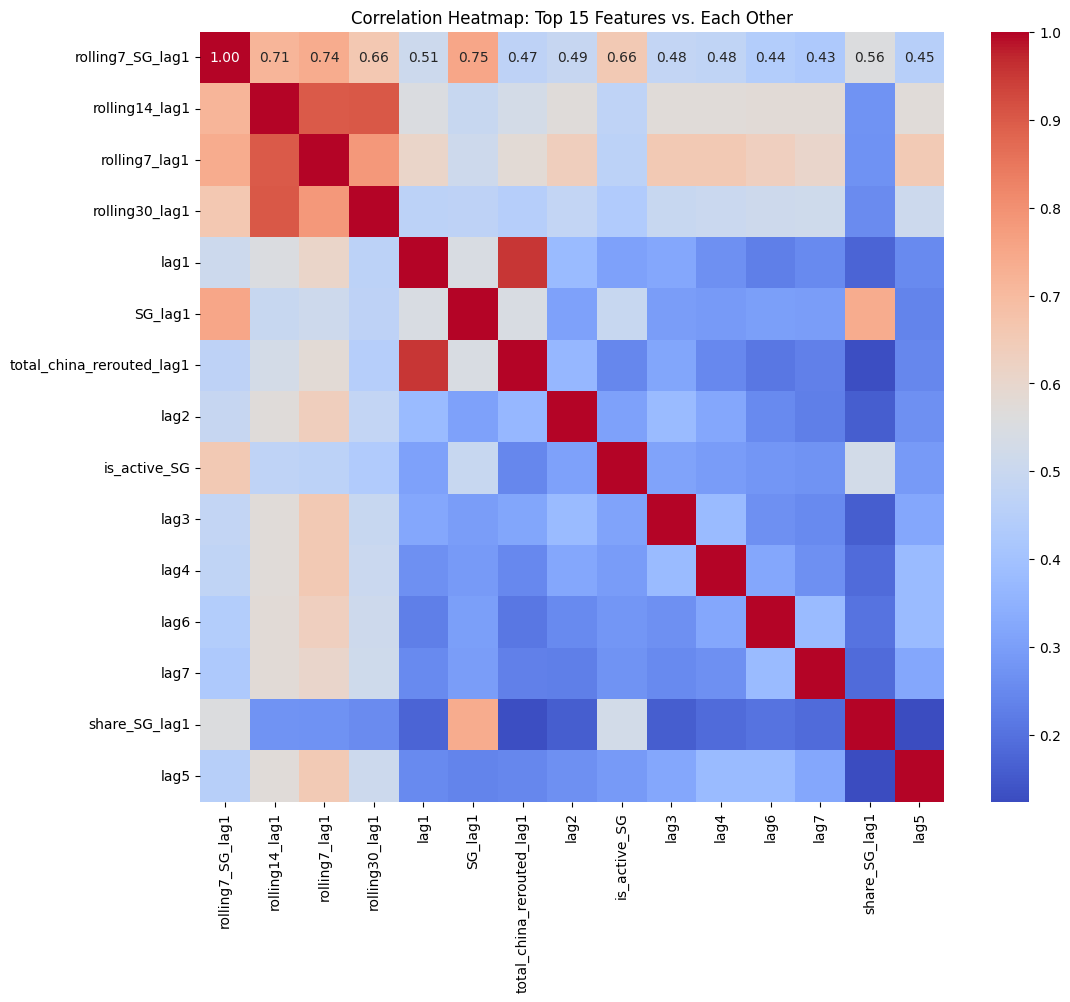

In [42]:
import matplotlib.pyplot as plt

# Select features only (exclude 'ds', 'y')
candidate_feats = [col for col in df_prophet.columns if col not in ['ds', 'y']]
df_corr = df_prophet[['y'] + candidate_feats].copy().dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Print top features most correlated with 'y'
top_corr = corr_matrix['y'].abs().sort_values(ascending=False)
print("Top 15 features correlated with package count:")
print(top_corr[1:16])  # skip the first which is y itself

# Plot heatmap of top 15 correlated features
import seaborn as sns
plt.figure(figsize=(12,10))
top_feats = top_corr.index[1:16]
sns.heatmap(df_corr[top_feats].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap: Top 15 Features vs. Each Other")
plt.show()


In [43]:
prophet_feature_combos = [
    ['rolling7_SG_lag1', 'rolling7_lag1', 'lag1', 'total_china_rerouted_lag1', 'SG_lag1'],        # Combo A
    ['rolling7_SG_lag1', 'lag1', 'lag2', 'SG_lag1'],                                              # Combo B
    ['rolling7_SG_lag1', 'rolling14_lag1', 'rolling30_lag1'],                                     # Combo C
    ['lag1', 'lag2', 'lag3', 'lag4'],                                                             # Combo D
    ['rolling7_SG_lag1', 'lag1', 'SG_lag1', 'is_active_SG', 'total_china_rerouted_lag1'],         # Combo E
    ['rolling7_SG_lag1', 'rolling7_lag1', 'lag1', 'SG_lag1', 'is_active_SG', 
     'total_china_rerouted_lag1', 'lag2'],                                                        # Combo F
]

results = []

for i, feats in enumerate(prophet_feature_combos):
    print(f"Trying combo {i+1}: {feats}")
    from prophet import Prophet
    # Prepare data for Prophet
    prophet_data = df_prophet[['ds', 'y'] + feats].dropna().copy()
    m = Prophet()
    for f in feats:
        m.add_regressor(f)
    model = m.fit(prophet_data)
    y_pred = m.predict(prophet_data)['yhat'].values
    y_true = prophet_data['y'].values
    # Metrics (manual version, so it works everywhere)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    results.append((mae, rmse, r2, feats))
    print(f"Combo {i+1} - MAE: {mae:.1f} | RMSE: {rmse:.1f} | R²: {r2:.4f}")

best_idx = np.argmin([r[0] for r in results])
print("\n==== Best Prophet Results ====")
mae, rmse, r2, feats = results[best_idx]
print(f"MAE={mae:.1f}, RMSE={rmse:.1f}, R²={r2:.4f}, Features={feats}")


Trying combo 1: ['rolling7_SG_lag1', 'rolling7_lag1', 'lag1', 'total_china_rerouted_lag1', 'SG_lag1']


20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] done processing
20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] done processing


Combo 1 - MAE: 1879.3 | RMSE: 2455.5 | R²: 0.3443
Trying combo 2: ['rolling7_SG_lag1', 'lag1', 'lag2', 'SG_lag1']


20:42:13 - cmdstanpy - INFO - Chain [1] start processing


Combo 2 - MAE: 1869.5 | RMSE: 2455.6 | R²: 0.3443
Trying combo 3: ['rolling7_SG_lag1', 'rolling14_lag1', 'rolling30_lag1']


20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing


Combo 3 - MAE: 1873.3 | RMSE: 2484.5 | R²: 0.3288
Trying combo 4: ['lag1', 'lag2', 'lag3', 'lag4']


20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing


Combo 4 - MAE: 1916.3 | RMSE: 2503.3 | R²: 0.3186
Trying combo 5: ['rolling7_SG_lag1', 'lag1', 'SG_lag1', 'is_active_SG', 'total_china_rerouted_lag1']


20:42:14 - cmdstanpy - INFO - Chain [1] start processing


Combo 5 - MAE: 1864.3 | RMSE: 2452.6 | R²: 0.3459
Trying combo 6: ['rolling7_SG_lag1', 'rolling7_lag1', 'lag1', 'SG_lag1', 'is_active_SG', 'total_china_rerouted_lag1', 'lag2']


20:42:14 - cmdstanpy - INFO - Chain [1] done processing


Combo 6 - MAE: 1855.7 | RMSE: 2445.5 | R²: 0.3497

==== Best Prophet Results ====
MAE=1855.7, RMSE=2445.5, R²=0.3497, Features=['rolling7_SG_lag1', 'rolling7_lag1', 'lag1', 'SG_lag1', 'is_active_SG', 'total_china_rerouted_lag1', 'lag2']


In [44]:
prophet_feature_combos = [
    # Combo 1: Top 15 correlated + important business flags
    ['rolling7_SG_lag1', 'rolling14_lag1', 'rolling7_lag1', 'rolling30_lag1', 'lag1',
     'SG_lag1', 'total_china_rerouted_lag1', 'lag2', 'is_active_SG', 'lag3', 'lag4',
     'lag6', 'lag7', 'share_SG_lag1', 'lag5', 'is_promo_day', 'is_holiday'],
    
    # Combo 2: All main lags, all rollings, all SG-related, all calendar flags
    ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7',
     'rolling7_lag1', 'rolling14_lag1', 'rolling30_lag1',
     'rolling7_SG_lag1', 'SG_lag1', 'is_active_SG', 'is_friday', 'day_of_week', 'month',
     'is_promo_day', 'is_holiday', 'is_after_holiday', 'is_manual_closure', 'is_closed_day',
     'is_post_event_window', 'day_after_closed'],
    
    # Combo 3: Top 20 by correlation with y (from your output) + promo/holiday
    [
        'rolling7_SG_lag1', 'rolling14_lag1', 'rolling7_lag1', 'rolling30_lag1', 'lag1',
        'SG_lag1', 'total_china_rerouted_lag1', 'lag2', 'is_active_SG', 'lag3',
        'lag4', 'lag6', 'lag7', 'share_SG_lag1', 'lag5', 'is_promo_day', 'is_holiday',
        'AE_lag1', 'CZ_lag1', 'growth_SG_lag1'
    ],
    
    # Combo 4: “Mega” set—take nearly everything except country shares/growths (to avoid insane multicollinearity)
    [
        'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7',
        'rolling7_lag1', 'rolling14_lag1', 'rolling30_lag1',
        'rolling7_SG_lag1', 'rolling7_AE_lag1', 'rolling7_CZ_lag1', 'rolling7_MY_lag1', 'rolling7_CN_lag1',
        'SG_lag1', 'AE_lag1', 'CZ_lag1', 'MY_lag1', 'CN_lag1',
        'is_active_SG', 'is_active_AE', 'is_active_CZ', 'is_active_MY', 'is_active_CN',
        'is_friday', 'day_of_week', 'month', 'is_promo_day', 'is_holiday', 'is_after_holiday',
        'is_manual_closure', 'is_closed_day', 'is_post_event_window', 'day_after_closed',
        'total_china_rerouted_lag1', 'china_rolling7_std_lag1'
    ],
]


In [45]:
results = []
import numpy as np
from prophet import Prophet

for i, feats in enumerate(prophet_feature_combos):
    print(f"Trying combo {i+1}: ({len(feats)} features) {feats}")
    prophet_data = df_prophet[['ds', 'y'] + feats].dropna().copy()
    m = Prophet()
    for f in feats:
        m.add_regressor(f)
    model = m.fit(prophet_data)
    y_pred = m.predict(prophet_data)['yhat'].values
    y_true = prophet_data['y'].values
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    results.append((mae, rmse, r2, feats))
    print(f"Combo {i+1} - MAE: {mae:.1f} | RMSE: {rmse:.1f} | R²: {r2:.4f}")

best_idx = np.argmin([r[0] for r in results])
print("\n==== Best Prophet Results (Tall Combos) ====")
mae, rmse, r2, feats = results[best_idx]
print(f"MAE={mae:.1f}, RMSE={rmse:.1f}, R²={r2:.4f}, Features={feats}")


Trying combo 1: (17 features) ['rolling7_SG_lag1', 'rolling14_lag1', 'rolling7_lag1', 'rolling30_lag1', 'lag1', 'SG_lag1', 'total_china_rerouted_lag1', 'lag2', 'is_active_SG', 'lag3', 'lag4', 'lag6', 'lag7', 'share_SG_lag1', 'lag5', 'is_promo_day', 'is_holiday']


20:43:37 - cmdstanpy - INFO - Chain [1] start processing
20:43:37 - cmdstanpy - INFO - Chain [1] done processing
20:43:38 - cmdstanpy - INFO - Chain [1] start processing


Combo 1 - MAE: 1848.6 | RMSE: 2437.7 | R²: 0.3538
Trying combo 2: (23 features) ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'rolling7_lag1', 'rolling14_lag1', 'rolling30_lag1', 'rolling7_SG_lag1', 'SG_lag1', 'is_active_SG', 'is_friday', 'day_of_week', 'month', 'is_promo_day', 'is_holiday', 'is_after_holiday', 'is_manual_closure', 'is_closed_day', 'is_post_event_window', 'day_after_closed']


20:43:38 - cmdstanpy - INFO - Chain [1] done processing
20:43:38 - cmdstanpy - INFO - Chain [1] start processing


Combo 2 - MAE: 1846.6 | RMSE: 2440.3 | R²: 0.3524
Trying combo 3: (20 features) ['rolling7_SG_lag1', 'rolling14_lag1', 'rolling7_lag1', 'rolling30_lag1', 'lag1', 'SG_lag1', 'total_china_rerouted_lag1', 'lag2', 'is_active_SG', 'lag3', 'lag4', 'lag6', 'lag7', 'share_SG_lag1', 'lag5', 'is_promo_day', 'is_holiday', 'AE_lag1', 'CZ_lag1', 'growth_SG_lag1']


20:43:38 - cmdstanpy - INFO - Chain [1] done processing


Combo 3 - MAE: 1842.9 | RMSE: 2423.4 | R²: 0.3614
Trying combo 4: (37 features) ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'rolling7_lag1', 'rolling14_lag1', 'rolling30_lag1', 'rolling7_SG_lag1', 'rolling7_AE_lag1', 'rolling7_CZ_lag1', 'rolling7_MY_lag1', 'rolling7_CN_lag1', 'SG_lag1', 'AE_lag1', 'CZ_lag1', 'MY_lag1', 'CN_lag1', 'is_active_SG', 'is_active_AE', 'is_active_CZ', 'is_active_MY', 'is_active_CN', 'is_friday', 'day_of_week', 'month', 'is_promo_day', 'is_holiday', 'is_after_holiday', 'is_manual_closure', 'is_closed_day', 'is_post_event_window', 'day_after_closed', 'total_china_rerouted_lag1', 'china_rolling7_std_lag1']


20:43:39 - cmdstanpy - INFO - Chain [1] start processing
20:43:39 - cmdstanpy - INFO - Chain [1] done processing


Combo 4 - MAE: 1818.9 | RMSE: 2394.0 | R²: 0.3768

==== Best Prophet Results (Tall Combos) ====
MAE=1818.9, RMSE=2394.0, R²=0.3768, Features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'rolling7_lag1', 'rolling14_lag1', 'rolling30_lag1', 'rolling7_SG_lag1', 'rolling7_AE_lag1', 'rolling7_CZ_lag1', 'rolling7_MY_lag1', 'rolling7_CN_lag1', 'SG_lag1', 'AE_lag1', 'CZ_lag1', 'MY_lag1', 'CN_lag1', 'is_active_SG', 'is_active_AE', 'is_active_CZ', 'is_active_MY', 'is_active_CN', 'is_friday', 'day_of_week', 'month', 'is_promo_day', 'is_holiday', 'is_after_holiday', 'is_manual_closure', 'is_closed_day', 'is_post_event_window', 'day_after_closed', 'total_china_rerouted_lag1', 'china_rolling7_std_lag1']


In [46]:
# Assumes df_prophet['ds'] is sorted and is datetime
N_TEST = 120
df_all = df_prophet.copy().dropna(subset=['y'])  # Make sure no NaN in y

train_df = df_all.iloc[:-N_TEST].reset_index(drop=True)
test_df  = df_all.iloc[-N_TEST:].reset_index(drop=True)

print(f"Train: {train_df.shape}, Test: {test_df.shape}")


Train: (896, 55), Test: (120, 55)


In [47]:
from prophet import Prophet

all_feats = [c for c in df_prophet.columns if c not in ['ds','y']]
m = Prophet()
for feat in all_feats:
    m.add_regressor(feat)
m = m.fit(train_df[['ds', 'y'] + all_feats])


20:45:19 - cmdstanpy - INFO - Chain [1] start processing
20:45:19 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
# Prophet expects all regressors in test_df to match train
future = test_df[['ds'] + all_feats].copy()

# Predict
forecast = m.predict(future)

# Prophet output yhat is prediction
y_test_pred = forecast['yhat'].values
y_test_true = test_df['y'].values


In [49]:
import numpy as np

mae = np.mean(np.abs(y_test_true - y_test_pred))
rmse = np.sqrt(np.mean((y_test_true - y_test_pred) ** 2))
y_bar = np.mean(y_test_true)
r2 = 1 - np.sum((y_test_true - y_test_pred) ** 2) / np.sum((y_test_true - y_bar) ** 2)

print(f"Prophet (Test) - MAE: {mae:.1f} | RMSE: {rmse:.1f} | R²: {r2:.4f}")


Prophet (Test) - MAE: 2487.3 | RMSE: 3044.8 | R²: -0.5940


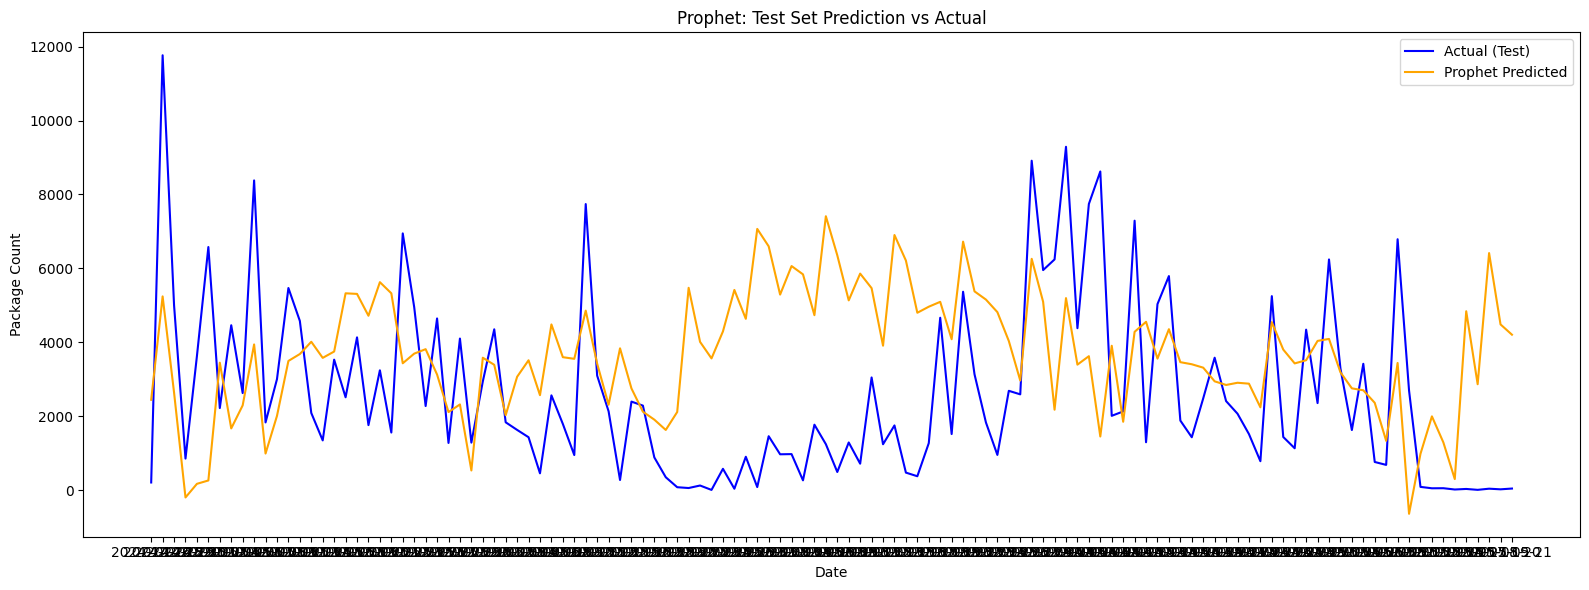

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(test_df['ds'], y_test_true, label='Actual (Test)', color='blue')
plt.plot(test_df['ds'], y_test_pred, label='Prophet Predicted', color='orange')
plt.legend()
plt.title("Prophet: Test Set Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Package Count")
plt.tight_layout()
plt.show()


In [51]:
from prophet import Prophet
import numpy as np

# Try a grid of possible values
changepoint_scales = [0.001, 0.01, 0.05, 0.1, 0.2]
seasonality_scales = [1.0, 5.0, 10.0, 15.0]
best_mae = np.inf
best_params = {}

for c in changepoint_scales:
    for s in seasonality_scales:
        m = Prophet(
            changepoint_prior_scale=c,
            seasonality_prior_scale=s,
            seasonality_mode='additive' # or 'multiplicative'
        )
        for feat in all_feats:
            m.add_regressor(feat)
        m.fit(train_df[['ds', 'y'] + all_feats])

        # Predict on test set
        future = test_df[['ds'] + all_feats]
        y_pred = m.predict(future)['yhat'].values
        y_true = test_df['y'].values
        mae = np.mean(np.abs(y_true - y_pred))
        print(f"cps={c}, sps={s} -> MAE={mae:.2f}")

        if mae < best_mae:
            best_mae = mae
            best_params = {'changepoint_prior_scale': c, 'seasonality_prior_scale': s}

print("Best params:", best_params)


20:47:30 - cmdstanpy - INFO - Chain [1] start processing
20:47:30 - cmdstanpy - INFO - Chain [1] done processing
20:47:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:47:30 - cmdstanpy - INFO - Chain [1] start processing
20:47:32 - cmdstanpy - INFO - Chain [1] done processing


cps=0.001, sps=1.0 -> MAE=2490.68


20:47:33 - cmdstanpy - INFO - Chain [1] start processing
20:47:33 - cmdstanpy - INFO - Chain [1] done processing
20:47:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:47:33 - cmdstanpy - INFO - Chain [1] start processing
20:47:35 - cmdstanpy - INFO - Chain [1] done processing


cps=0.001, sps=5.0 -> MAE=2487.34


20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:38 - cmdstanpy - INFO - Chain [1] done processing


cps=0.001, sps=10.0 -> MAE=2487.56


20:47:39 - cmdstanpy - INFO - Chain [1] start processing
20:47:39 - cmdstanpy - INFO - Chain [1] done processing
20:47:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:47:39 - cmdstanpy - INFO - Chain [1] start processing
20:47:42 - cmdstanpy - INFO - Chain [1] done processing


cps=0.001, sps=15.0 -> MAE=2487.60


20:47:42 - cmdstanpy - INFO - Chain [1] start processing
20:47:42 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1.0 -> MAE=2283.65


20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5.0 -> MAE=2344.73


20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=10.0 -> MAE=2153.52


20:47:44 - cmdstanpy - INFO - Chain [1] start processing
20:47:44 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=15.0 -> MAE=2223.72


20:47:44 - cmdstanpy - INFO - Chain [1] start processing
20:47:44 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1.0 -> MAE=2450.64


20:47:45 - cmdstanpy - INFO - Chain [1] start processing
20:47:45 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=5.0 -> MAE=2443.99


20:47:45 - cmdstanpy - INFO - Chain [1] start processing
20:47:45 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=10.0 -> MAE=2487.33


20:47:46 - cmdstanpy - INFO - Chain [1] start processing
20:47:46 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=15.0 -> MAE=2483.99


20:47:46 - cmdstanpy - INFO - Chain [1] start processing
20:47:46 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=1.0 -> MAE=2447.85


20:47:47 - cmdstanpy - INFO - Chain [1] start processing
20:47:47 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5.0 -> MAE=2438.42


20:47:47 - cmdstanpy - INFO - Chain [1] start processing
20:47:48 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=10.0 -> MAE=2449.41


20:47:48 - cmdstanpy - INFO - Chain [1] start processing
20:47:48 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=15.0 -> MAE=2460.68


20:47:48 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1.0 -> MAE=2495.39


20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5.0 -> MAE=2501.57


20:47:50 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=10.0 -> MAE=2505.07


20:47:50 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=15.0 -> MAE=2488.11
Best params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


In [55]:
from prophet import Prophet
import numpy as np

# Refit on TRAIN set with best params
m = Prophet(
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=10.0,
    seasonality_mode='additive'  # or 'multiplicative' if you want to try
)
for feat in all_feats:
    m.add_regressor(feat)
m.fit(train_df[['ds', 'y'] + all_feats])

# --- Predict on TRAIN ---
forecast_train = m.predict(train_df[['ds'] + all_feats])
y_train_true = train_df['y'].values
y_train_pred = forecast_train['yhat'].values

# --- Predict on TEST ---
forecast_test = m.predict(test_df[['ds'] + all_feats])
y_test_true = test_df['y'].values
y_test_pred = forecast_test['yhat'].values

# --- Calculate Metrics ---
def metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    return mae, rmse, r2

mae_train, rmse_train, r2_train = metrics(y_train_true, y_train_pred)
mae_test, rmse_test, r2_test = metrics(y_test_true, y_test_pred)

print(f"Train MAE: {mae_train:.1f}\nTrain RMSE: {rmse_train:.1f}\nTrain R²: {r2_train:.4f}\n")
print(f"Test MAE: {mae_test:.1f}\nTest RMSE: {rmse_test:.1f}\nTest R²: {r2_test:.4f}")


20:49:20 - cmdstanpy - INFO - Chain [1] start processing
20:49:20 - cmdstanpy - INFO - Chain [1] done processing


Train MAE: 1818.5
Train RMSE: 2375.9
Train R²: 0.3824

Test MAE: 2153.5
Test RMSE: 2577.6
Test R²: -0.1424


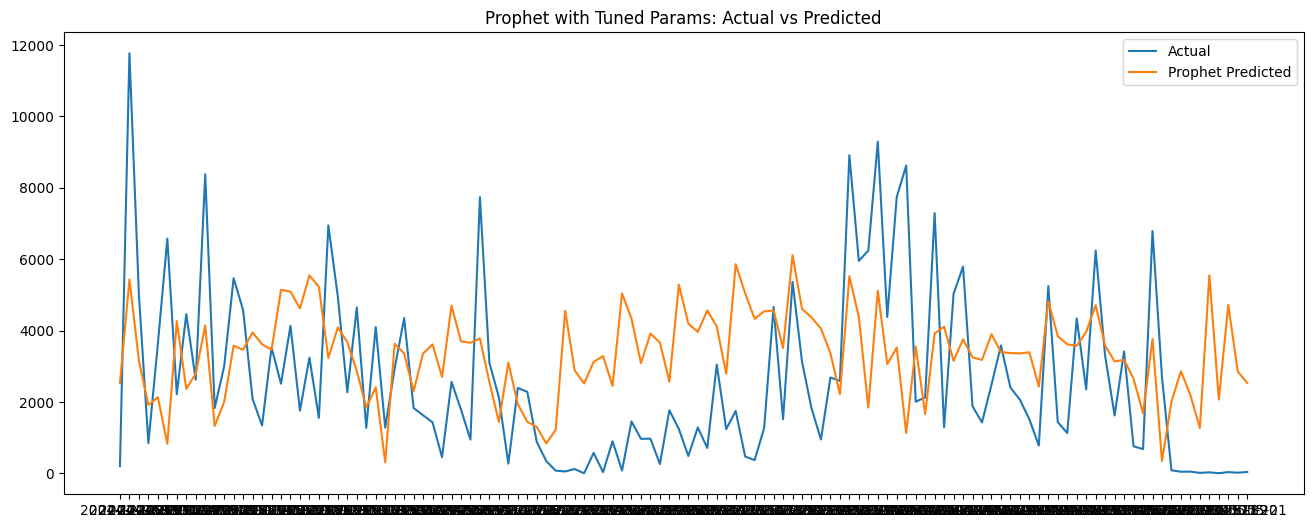

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(test_df['ds'], y_true, label='Actual')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted')
plt.legend()
plt.title("Prophet with Tuned Params: Actual vs Predicted")
plt.show()


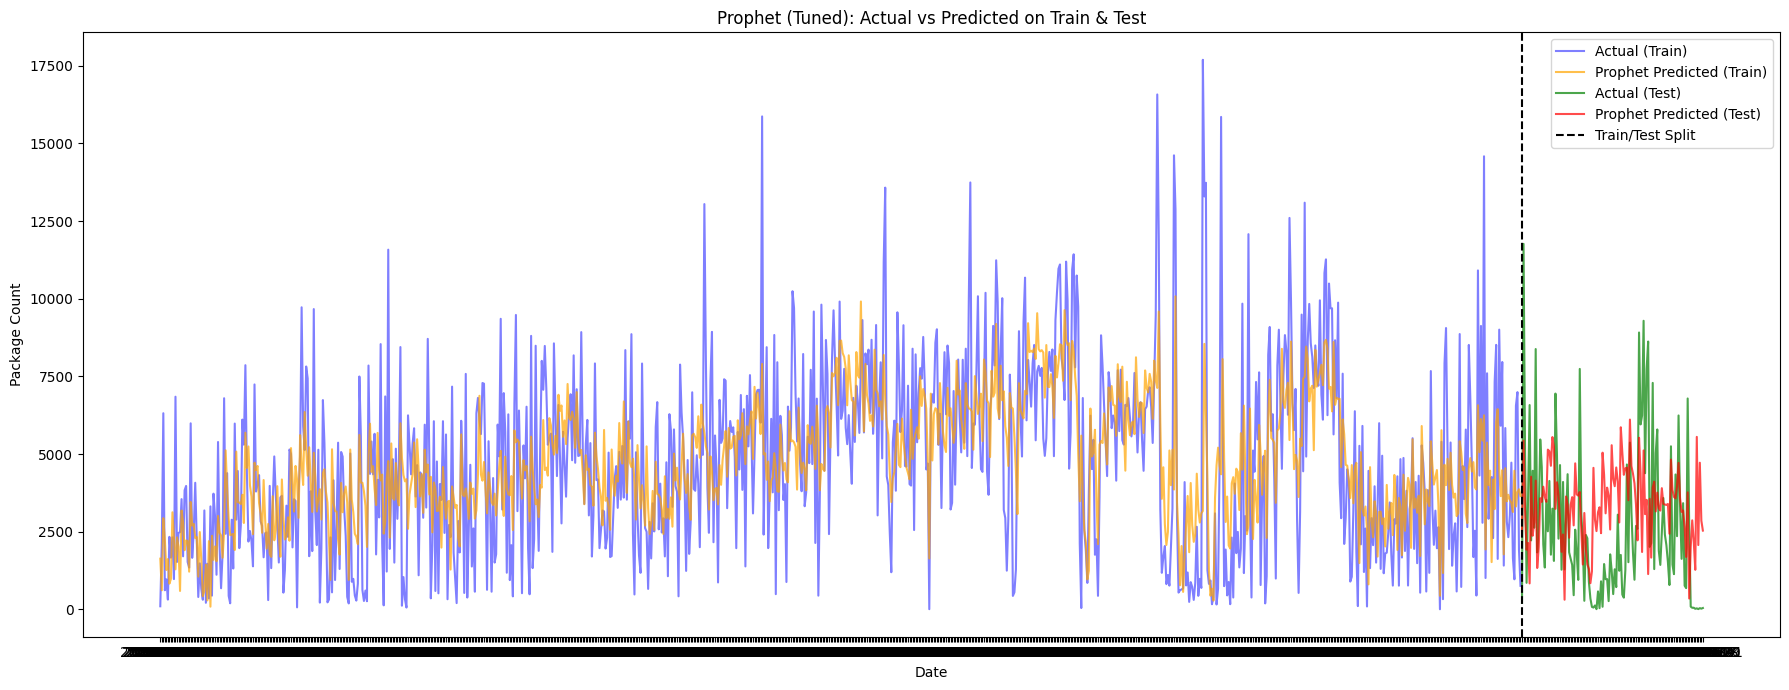

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,7))
plt.plot(train_df['ds'], y_train_true, label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(train_df['ds'], y_train_pred, label='Prophet Predicted (Train)', color='orange', alpha=0.7)
plt.plot(test_df['ds'], y_test_true, label='Actual (Test)', color='green', alpha=0.7)
plt.plot(test_df['ds'], y_test_pred, label='Prophet Predicted (Test)', color='red', alpha=0.7)
plt.axvline(test_df['ds'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title("Prophet (Tuned): Actual vs Predicted on Train & Test")
plt.xlabel("Date")
plt.ylabel("Package Count")
plt.tight_layout()
plt.show()


# ARIMAX

In [58]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Suppose df is your DataFrame and you already shifted lags
# Choose the best features you want (for a start, just the top lags and rolling features)
best_feats = [
    'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7',
    'rolling7_lag1', 'rolling14_lag1', 'rolling30_lag1',
    'SG_lag1', 'AE_lag1', 'CZ_lag1', 'MY_lag1', 'CN_lag1',
    'total_china_rerouted_lag1'
]
y = df['y'].shift(-1).iloc[7:]  # (assuming lags up to 7)
X = df[best_feats].iloc[7:]

# Split like before (e.g., last N days test)
N_test = 120
X_train, X_test = X.iloc[:-N_test], X.iloc[-N_test:]
y_train, y_test = y.iloc[:-N_test], y.iloc[-N_test:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (896, 16) (896,)
Test shape: (120, 16) (120,)


In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX
sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,1,1),        # Try (1,1,1) to start; tune if needed
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_res = sarimax_model.fit(disp=False)

# Predict
# After fitting sarimax_res as before:

N_test = X_test.shape[0]
forecast_obj = sarimax_res.get_forecast(steps=N_test, exog=X_test)
y_pred = forecast_obj.predicted_mean

# y_pred is aligned with X_test (same number of rows)



d:\program inst\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX Test MAE: 1966.5
SARIMAX Test RMSE: 2379.1
SARIMAX Test R²: 0.0265


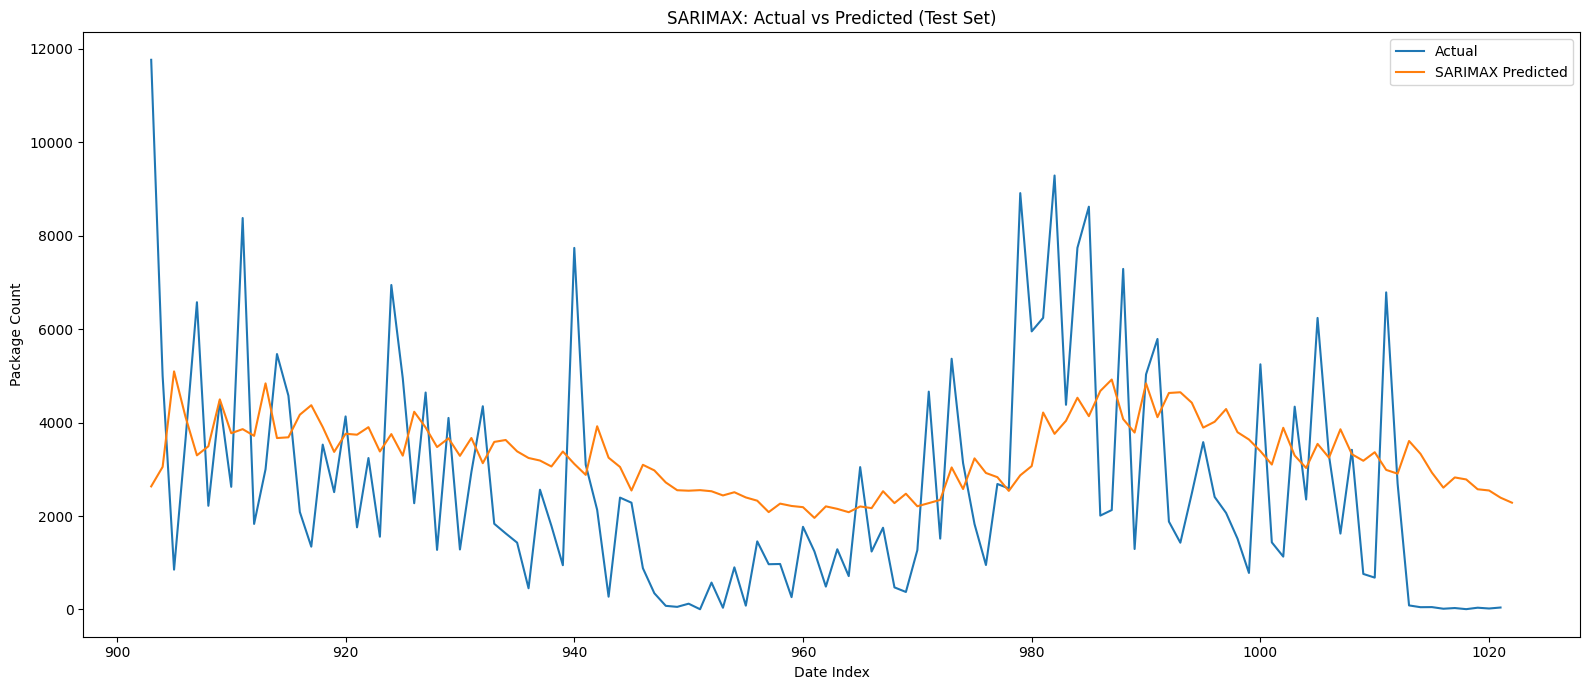

In [61]:
# Evaluation
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print(f"SARIMAX Test MAE: {mae:.1f}")
print(f"SARIMAX Test RMSE: {rmse:.1f}")
print(f"SARIMAX Test R²: {r2:.4f}")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(16,7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='SARIMAX Predicted')
plt.legend()
plt.title("SARIMAX: Actual vs Predicted (Test Set)")
plt.xlabel("Date Index")
plt.ylabel("Package Count")
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd
import numpy as np

# Load your CSV
full_features_df = pd.read_csv("regression_df_official.csv")
full_features_df = full_features_df.drop(columns=['days_since_promo'], errors='ignore')
# --------- DROP UNUSABLES ---------
drop_cols = [
    'date', 'package_count',   # Don't use target or date as features
    'is_open_day', 'is_big_jump', 'is_outlier', 'is_iqr_outlier' , 'days_since_promo'
]
exog_features = [c for c in full_features_df.columns if c not in drop_cols]

# --------- ENCODE CATEGORICALS ---------
for col in full_features_df[exog_features].select_dtypes(include='object').columns:
    full_features_df[col] = full_features_df[col].astype('category').cat.codes

# --------- DROP NA ROWS (from shifting/rolling) ---------


In [79]:
full_features_df.columns

Index(['date', 'package_count', 'day_of_week', 'is_friday', 'is_holiday',
       'is_after_holiday', 'is_manual_closure', 'is_closed_day',
       'is_post_event_window', 'is_open_day', 'day_after_closed', 'lag1',
       'lag7', 'rolling7', 'rolling14', 'rolling30', 'growth_rate',
       'is_active_SG', 'is_active_CZ', 'is_active_AE', 'is_active_MY',
       'is_active_CN', 'SG', 'CZ', 'AE', 'MY', 'CN', 'FR', 'NL', 'growth_SG',
       'growth_CZ', 'growth_AE', 'growth_MY', 'growth_CN', 'rolling7_SG',
       'rolling7_CZ', 'rolling7_AE', 'rolling7_MY', 'rolling7_CN', 'share_SG',
       'share_CZ', 'share_AE', 'share_MY', 'share_CN', 'month', 'day_of_year',
       'weekofyear', 'n_active_china_routes', 'dominant_country',
       'china_rolling7_std', 'is_promo_day', 'total_china_rerouted',
       'is_big_jump', 'is_outlier', 'is_iqr_outlier'],
      dtype='object')

In [80]:
# Check number of missing values in each feature column
missing_counts = full_features_df.isnull().sum()

# Only show features with missing values
missing_counts = missing_counts[missing_counts > 0]
print("Features with missing values and their counts:\n", missing_counts)


Features with missing values and their counts:
 lag1           1
lag7           7
growth_rate    1
dtype: int64


In [81]:
full_features_df = full_features_df.dropna(subset=exog_features + ['package_count']).reset_index(drop=True)

# --------- DEFINE X, y ---------
X = full_features_df[exog_features]
y = full_features_df['package_count']

# --------- TRAIN/TEST SPLIT (e.g. last 120 days as test) ---------
test_size = 120
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

print("Features used for SARIMAX:", list(X.columns))
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Features used for SARIMAX: ['day_of_week', 'is_friday', 'is_holiday', 'is_after_holiday', 'is_manual_closure', 'is_closed_day', 'is_post_event_window', 'day_after_closed', 'lag1', 'lag7', 'rolling7', 'rolling14', 'rolling30', 'growth_rate', 'is_active_SG', 'is_active_CZ', 'is_active_AE', 'is_active_MY', 'is_active_CN', 'SG', 'CZ', 'AE', 'MY', 'CN', 'FR', 'NL', 'growth_SG', 'growth_CZ', 'growth_AE', 'growth_MY', 'growth_CN', 'rolling7_SG', 'rolling7_CZ', 'rolling7_AE', 'rolling7_MY', 'rolling7_CN', 'share_SG', 'share_CZ', 'share_AE', 'share_MY', 'share_CN', 'month', 'day_of_year', 'weekofyear', 'n_active_china_routes', 'dominant_country', 'china_rolling7_std', 'is_promo_day', 'total_china_rerouted']
Train shape: (896, 49)
Test shape: (120, 49)


In [82]:
import statsmodels.api as sm

# Pick your (p,d,q) orders, e.g. (1,1,1). You may tune these.
sarimax_model = sm.tsa.SARIMAX(
    y_train, 
    exog=X_train, 
    order=(1,1,1),       # ARIMA orders; tune if needed
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_res = sarimax_model.fit(disp=False)


d:\program inst\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [83]:
N_test = X_test.shape[0]

# Predict only the test set
forecast_obj = sarimax_res.get_forecast(steps=N_test, exog=X_test)
y_pred = forecast_obj.predicted_mean


In [84]:
# Manual metrics since your sklearn is old:
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print(f"SARIMAX Test MAE: {mae:.1f}")
print(f"SARIMAX Test RMSE: {rmse:.1f}")
print(f"SARIMAX Test R²: {r2:.4f}")


SARIMAX Test MAE: 23222.3
SARIMAX Test RMSE: 149723.5
SARIMAX Test R²: -3853.4705


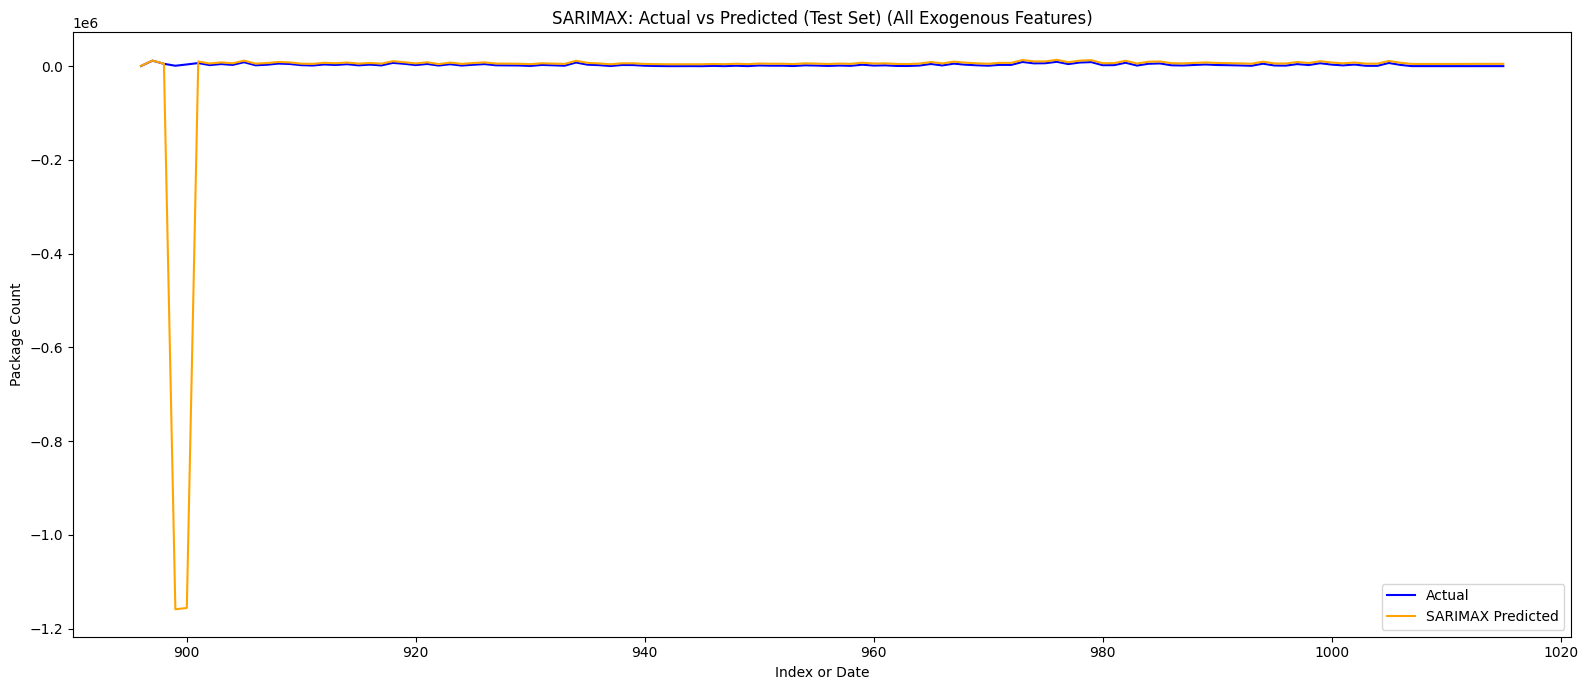

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, y_pred.values, label='SARIMAX Predicted', color='orange')
plt.legend()
plt.title("SARIMAX: Actual vs Predicted (Test Set) (All Exogenous Features)")
plt.xlabel("Index or Date")
plt.ylabel("Package Count")
plt.tight_layout()
plt.show()


In [88]:
print(list(full_features_df.columns))



['date', 'package_count', 'day_of_week', 'is_friday', 'is_holiday', 'is_after_holiday', 'is_manual_closure', 'is_closed_day', 'is_post_event_window', 'is_open_day', 'day_after_closed', 'lag1', 'lag7', 'rolling7', 'rolling14', 'rolling30', 'growth_rate', 'is_active_SG', 'is_active_CZ', 'is_active_AE', 'is_active_MY', 'is_active_CN', 'SG', 'CZ', 'AE', 'MY', 'CN', 'FR', 'NL', 'growth_SG', 'growth_CZ', 'growth_AE', 'growth_MY', 'growth_CN', 'rolling7_SG', 'rolling7_CZ', 'rolling7_AE', 'rolling7_MY', 'rolling7_CN', 'share_SG', 'share_CZ', 'share_AE', 'share_MY', 'share_CN', 'month', 'day_of_year', 'weekofyear', 'n_active_china_routes', 'dominant_country', 'china_rolling7_std', 'is_promo_day', 'total_china_rerouted', 'is_big_jump', 'is_outlier', 'is_iqr_outlier']
